In [ ]:
### Notebook used to test & compare outputs between MATLAB & Python implementations
## Run cell by cell, some cells N/A for certain methods

In [1]:
import sys
from scipy import fft
from scipy.fft import fftshift
import numpy as np
from multiprocessing import Pool
from scipy.stats import pearsonr
import Bio
from Bio.Phylo.TreeConstruction import *
from functools import partial

import pywt
# import os

from statistics import median, mean
from one_dimensional_num_mapping import *

# plotting

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from classification import classify_dismat
from preprocessing import preprocessing
from helpers import *

from cgr import *
from visualisation import dimReduction
# set up
# if os.path.exists("Sequence_database.idx"):
#     os.remove("Sequence_database.idx")


In [2]:
data_set = './DataBase/Primates'


In [3]:
test_set = 'NoData'
seq_to_test = 0
min_seq_len = 0
max_clust_size = 5000000
frags_per_seq = 1

methods_list = {0: cgr, 1: num_mapping_PP, 2: num_mapping_Int, 3: num_mapping_IntN, 4: num_mapping_Real, 5: num_mapping_Doublet, 6: num_mapping_Codons, 7: num_mapping_Atomic,
                8: num_mapping_EIIP, 9: num_mapping_AT_CG, 10: num_mapping_justA, 11: num_mapping_justC, 12: num_mapping_justG, 13: num_mapping_justT, 14: 'PuPyCGR', 15: '1DPuPyCGR'}


In [4]:
# change method number referring the variable above (between 0 and 15)

method_num = 0
method = methods_list.get(method_num) 
# all matlab test .mat files were run at k=4
k_val = 7  # used only for CGR-based representations(if methodNum=1,15,16)


In [5]:
seq_dict, number_of_clusters, total_seq, cluster_dict = preprocessing(data_set,max_clust_size)


In [6]:
# variable holding all the keys (accession numbers) for corresponding clusters

keys = list(cluster_dict.keys())

values = list(cluster_dict.values())
# Could be parallelized in the future

seqs_length = [len(seq_dict[keys[i]].seq) for i in range(total_seq)]
med_len = median(seqs_length)
labels = [cluster_dict[x] for x in seq_dict.keys()]
fft_output_list = []
abs_fft_output_list = []
cgr_output_list = []
seq_new_list = []
seq_list=[]


In [7]:
total_seq

148

In [8]:
def compute_cgr_PuPyCGR(seq_index):
    # seqs is the sequence database, it is being called by accession number
    # (keys) which is being iterated over all seq_index,
    # (count of all sequences in uploaded dataset) .seq calls the string
    seq = str(seq_dict[keys[seq_index]].seq)
    seq_new = seq
    if method_num == 14:
        seq_new = seq_new.replace('G', 'A')
        seq_new = seq_new.replace('C', 'T')
    cgr_output = cgr(seq_new, 'ACGT', k_val)  # shape:[2^k, 2^k]
    # shape:[2^k, 2^k] # may not be appropriate to take by column
    # axis=0 takes fft by column, consistent with MATLAB 
    fft_output = fft.fft(cgr_output,axis=0)
    # order='F' flattens the array in fortran index consistent with MATLAB, shape: [1,2^k*2^k], list makes sorting easy for comparison of distance matrices
    abs_fft_output = np.abs(fft_output.flatten(order='F'))
    return abs_fft_output, fft_output, cgr_output, seq_new, seq  # flatted into 1d array


In [9]:
def compute_1DPuPyCGR(seq_index):
    seq = str(seq_dict[keys[seq_index]].seq)
    # creates PuPyCGR
    seq_new = seq.replace('G', 'A')
    seq_new = seq_new.replace('C', 'T')
    cgr_raw = cgr(seq_new, 'ACGT', k_val)
    # takes only the last (bottom) row but all columns of cgr to make 1DPuPyCGR
    cgr_output = cgr_raw[-1, :]
    # shape:[1, 2^k] # may not be appropriate to take by column
    fft_output = fft.fft(cgr_output)
    abs_fft_output = np.abs(fft_output.flatten(order='F'))
    return abs_fft_output, fft_output, cgr_output, seq_new, seq # flatted into 1d array


In [ ]:
def one_dimensional_num_mapping_wrapper(seq_index):
    # normalize sequences to median sequence length of cluster
    seq = str(seq_dict[keys[seq_index]].seq)
    if len(seq) >= med_len:
        seq_new = seq[0:round(med_len)]
    else:
        seq_new=seq
    num_seq = method(seq_new)
    if len(num_seq) < med_len:
        pad_width = int(med_len - len(num_seq))
        num_seq = pywt.pad(num_seq, pad_width, 'antisymmetric')[pad_width:]
    fft_output = fft.fft(num_seq)
    abs_fft_output = np.abs(fft_output.flatten()) #order='F' for testing abs_fft_outputs vs matlab
    return abs_fft_output, fft_output, num_seq, seq


In [10]:
def compute_pearson_coeffient(x, y):
    r = pearsonr(x, y)[0]
    normalized_r = (1-r)/2
    return normalized_r

def compute_pearson_coeffient_wrapper(i, j, abs_fft_output_list):
    # print(abs_fft_output_list)
    # x = abs_fft_output_list[i]
    # y = abs_fft_output_list[indices[1]]
    # print(x)
    # print(y)
    return compute_pearson_coeffient(abs_fft_output_list[i], abs_fft_output_list[j])


In [ ]:
# def phylogenetic_tree(distance_matrix):
#     names = keys
#     matrix = triangle_matrix
#     distance_matrix = DistanceMatrix(names, matrix)
#     constructor = DistanceTreeConstructor()
#     nj_tree = constructor.nj(distance_matrix)
#     # newick may not be need to be quoted
#     neighbour_joining_tree = nj_tree.format('newick')
#     upgma = constructor.upgma(distance_matrix)
#     upgma_tree = upgma.format('newick')
#     print(upgma_tree, file=tree_print)
#     # can add code here for visualization with matplotlib


In [11]:
print('Generating numerical sequences, applying DFT, computing magnitude spectra .... \n')
for seq_index in range(total_seq):
    if method_num == 0 or method_num == 14:
        abs_fft_output, fft_output, cgr_output, seq_new, seq = compute_cgr_PuPyCGR(seq_index)
        abs_fft_output_list.append(abs_fft_output)
        fft_output_list.append(fft_output)
        cgr_output_list.append(cgr_output)
        seq_new_list.append(seq_new)
        seq_list.append(seq)
        
    elif method_num == 15:
        abs_fft_output, fft_output, cgr_output, seq_new, seq = compute_1DPuPyCGR(seq_index)
        abs_fft_output_list.append(abs_fft_output)
        fft_output_list.append(fft_output)
        cgr_output_list.append(cgr_output)
        seq_new_list.append(seq_new)
        seq_list.append(seq)

    else:
        abs_fft_output, fft_output, seq_new, seq = one_dimensional_num_mapping_wrapper(seq_index)
        fft_output_list.append(fft_output)
        abs_fft_output_list.append(abs_fft_output)
        seq_new_list.append(seq_new)
        seq_list.append(seq)

Generating numerical sequences, applying DFT, computing magnitude spectra .... 



In [12]:
print('Building distance matrix')
distance_matrix = []
for i in range(total_seq):
    for j in range(total_seq):
        distance_matrix.append(compute_pearson_coeffient_wrapper(i,j,abs_fft_output_list)) 
distance_matrix = np.array(distance_matrix).reshape(total_seq, total_seq)
np.savetxt('distmat.txt', distance_matrix)


Building distance matrix


In [ ]:
    # print('Building Phylogenetic Trees')
    # matrix_list = distance_matrix.tolist()
    # triangle_matrix = []
    # # loop to create triangle matrix as nested list
    # for i in range(total_seq):
    #     row = []
    #     row = (matrix_list[i][0:i+1])
    #     triangle_matrix.append(row)
    # # change filename to unique ID
    # tree_print = open('upgma.tree', 'a')
    # phylogenetic_tree(triangle_matrix)
    # tree_print.close()

In [13]:
    print('Performing classification .... \n')
    folds = 10
    if (total_seq < folds):
        folds = total_seq
    mean_accuracy, accuracies = classify_dismat(distance_matrix, labels, folds, total_seq)
    # accuracy,avg_accuracy, clNames, cMat
    # accuracies = [accuracy, avg_accuracy];
    print('Classification accuracy 5 classifiers\n', accuracies)
    print('**** Processing completed ****\n')

Performing classification .... 

Classification accuracy 5 classifiers
 [[LinearDiscriminantAnalysis(), SVC(kernel='linear'), SVC(degree=2, kernel='poly'), KNeighborsClassifier(), SVC()], [90.95238095238096, 97.72486772486774, 87.989417989418, 94.65608465608466, 96.98412698412699]]
**** Processing completed ****



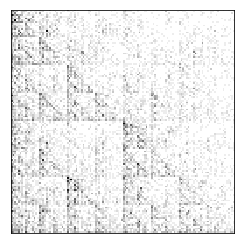

In [14]:
# Run only for CGR plotting
plt.matshow(cgr_output_list[0],cmap=cm.gray_r)
plt.xticks([])
plt.yticks([])
plt.savefig('/Users/dolteanu/local_documents/Coding/MLDSP_github/plots/cgr.png')


In [ ]:
# Run this cell for 1D numerical representations Fourier spectrum
median = int(med_len)
# fftshift the magnitude spectrum (required to visualize)
shifted_abs_fft = fftshift(abs_fft_output_list[0])
fig3, ax = plt.subplots(nrows=1, ncols=1)
# normalize the x axis to the length with -ve on left & +ve on right 
fVals = np.arange(start=-median/2, stop=median/2)/median
ax.plot(fVals,shifted_abs_fft)
ax.set_title('Double Sided FFT - with FFTShift')
ax.set_xlabel('Normalized Frequency')
ax.set_ylabel('|DFT Values|')
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_xticks(np.arange(-0.5, 0.5+0.1,0.1))

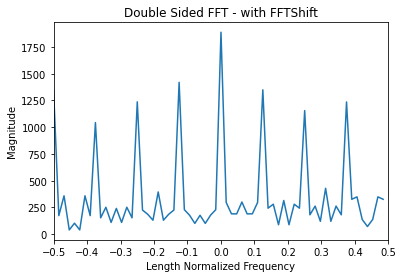

In [15]:
# Run this cell for 2D numerical representations (cgr;DOESNT WORK FOR Pu Py cgr YET) Fourier spectrum
# see above for comments
# get length of flattened cgr 
length = (2**k_val)**2 
shifted_abs_fft = fftshift(abs_fft_output_list[0])
fig4, ax = plt.subplots(nrows=1, ncols=1)
fVals = np.arange(start=-length/2, stop=length/2)/length
ax.plot(fVals,shifted_abs_fft)
ax.set_title('Double Sided FFT - with FFTShift')
ax.set_xlabel('Length Normalized Frequency')
ax.set_ylabel('Magnitude')
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_xticks(np.arange(-0.5, 0.5+0.1,0.1))

In [ ]:
import h5py
matlab = h5py.File('/Users/dolteanu/local_documents/Coding/MLDSP_github/DataBase/Dengue.mat', 'r')
mat_data = matlab.get(data)

In [ ]:
s = matlab.get('s')

In [ ]:
# Save entire matlab workspace as .mat 
# Use matlab mldsp version from github as variables have been added for testing; make sure k_val (where applicable) and methods match
from scipy.io import loadmat
#load .mat file from your machine
matlab = loadmat('/Users/dolteanu/local_documents/Coding/MLDSP_github/DataBase/Dengue.mat',simplify_cells=True)
locals().update(matlab)

In [ ]:
# Testing convention in this notebook: python variable on the left, matlab variable on the right
# compare accession number
keys==AcNmb

In [ ]:
len(keys)==len(AcNmb)

In [ ]:
#compare raw input sequences
seq_list==Seq

In [ ]:
len(seq_list)==len(Seq)

In [ ]:
#Run only for cgr based methods
# compare output sequences for cgr methods; regular cgr will be the same as previous cell since raw sequence is used for cgr generation
seq_new_list==sequence

In [ ]:
# Run only for 1D numerical representation methods
# Compare output of numerical representation
for thing in range(total_seq):
    print(seq_new_list[thing]==nmValSH[thing])

In [ ]:
len(seq_new_list)==len(nmValSH)

In [ ]:
# Run only for cgr methods
# compare CGRs
for thing in range(total_seq):
    print(True==np.allclose(cgr_output_list[thing],nmValSH[thing]))
        

In [ ]:
# Compare fft outputs
for thing in range(total_seq):
    print(np.allclose(fft_output_list[thing],f[thing]))

In [ ]:
# Compare magnitudes of ffts
for thing in range(total_seq):
    print(np.allclose(abs_fft_output_list[thing],lg[thing]))


In [ ]:
#Compare distance matrices
#modify exponent of 'rtol' to find similarity of dist mats, atol should be left untouched as it tests precision of zeros (diagonal)
np.allclose(distance_matrix,disMat,atol=1e-15,rtol=1e-11)

In [ ]:
#Compare MDS outputs-currently not matching
scaled_distance_matrix = dimReduction(distance_matrix, n_dim=3, method='pca')
np.isclose(scaled_distance_matrix,Y,rtol=1e0)

In [ ]:
print("LinearDiscriminant","LinearSVM","QuadraticSVM","FineKNN","SubspaceDiscriminant","SubspaceKNN"+str(accuracy))
